In this notebook, we introduce how to train xgboost to detect fraud
### Load Data

In [1]:
import openmldb
import shap

shap.initjs()
db = openmldb.dbapi.connect(zk='127.0.0.1:2181',zkPath='/openmldb')
openmldb.sql_magic.register(db)

/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.9/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@753: Client environment:zookeeper.version=zookeeper C client 3.4.14
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@757: Client environment:host.name=8d6d57ba4d85
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@764: Client environment:os.name=Linux
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@765: Client environment:os.arch=5.10.16.3-microsoft-standard-WSL2
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@766: Client environment:os.version=#1 SMP Fri Apr 2 22:23:49 UTC 2021
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@774: Client environment:user.name=(null)
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@782: Client environment:user.home=/root
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@log_env@794: Client environment:user.dir=/work/adops
2023-07-13 02:51:01,155:2799(0x7fc895ef2740):ZOO_INFO@zookeeper_init@827: Initiating clie

The database and table names:

In [2]:
db_name = "adops"
table_name = "fraud_detection"
%sql create database if not exists {db_name};
%sql use {db_name};
%sql create table if not exists $table_name (ip int, app int, device int, os int, channel int, click_time timestamp, attributed_time timestamp, is_attributed int);

Success to execute sql
Success to execute sql
Success to execute sql


I0713 02:51:05.356339  3020 zk_client.cc:58] node watcher with event type 3, state 3


Offline load data and extract feature

In [3]:
%sql set @@execute_mode='offline';
%sql set @@sync_job=true;

Success to execute sql
Success to execute sql


In [4]:
%sql load data infile 'file:///work/adops/data/train_sample.csv' into table $table_name options(mode='overwrite');

Success to execute sql


I0713 02:51:36.922760  3020 zk_client.cc:58] node watcher with event type 3, state 3


In [5]:
%sql select * from $table_name limit 10;

+----------------------+
| !%$FORMAT_STRING_KEY |
+----------------------+
            |p,app,device,os,channel,click_time,attributed_time,is_attributed
            |7540,12,1,13,497,2017-11-07 09:30:38.0,null,0
            |05560,25,1,17,259,2017-11-07 13:40:27.0,null,0
            |01424,12,1,19,212,2017-11-07 18:05:24.0,null,0
            |4584,13,1,13,477,2017-11-07 04:58:08.0,null,0
            |8413,12,1,1,178,2017-11-09 09:00:09.0,null,0
            |3663,3,1,17,115,2017-11-09 01:22:13.0,null,0
            |7059,1,1,17,135,2017-11-09 01:17:58.0,null,0
            |21505,9,1,25,442,2017-11-07 10:01:53.0,null,0
            |92967,2,2,22,364,2017-11-08 09:35:17.0,null,0
            |43636,3,1,19,135,2017-11-08 12:35:26.0,null,0
|                      |
+----------------------+


W0713 02:51:51.484153  2799 sql_cluster_router.cc:2659] offline sync SELECT will show output without the data integrity promise. And it will use local filesystem of TaskManager, it's dangerous to select a large result. You'd better use SELECT INTO to get the correct result.


In [6]:
sql_part = f"""
select is_attributed, app, device, os, channel, hour(click_time) as hour, day(click_time) as day, 
count(channel) over w1 as qty, 
count(channel) over w2 as ip_app_count, 
count(channel) over w3 as ip_app_os_count  
from {table_name} 
window 
w1 as (partition by ip order by click_time ROWS_RANGE BETWEEN 1h PRECEDING AND CURRENT ROW), 
w2 as(partition by ip, app order by click_time ROWS_RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
w3 as(partition by ip, app, os order by click_time ROWS_RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
"""

train_feature_dir='/tmp/train_feature'

In [7]:
%sql {sql_part} INTO OUTFILE '{train_feature_dir}' OPTIONS(mode='overwrite');

+----+-------------------+----------+---------------+---------------+-------------------------------+----------+---------------------+-------+
| id |      job_type     |  state   |   start_time  |    end_time   |           parameter           | cluster  |    application_id   | error |
+----+-------------------+----------+---------------+---------------+-------------------------------+----------+---------------------+-------+
| 3  | ExportOfflineData | FINISHED | 1689216729210 | 1689216741391 | /tmp/sql-13277917923812598707 | local[*] | local-1689216731379 |       |
+----+-------------------+----------+---------------+---------------+-------------------------------+----------+---------------------+-------+


In [8]:
import utils
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

train_feature_dir='/tmp/train_feature'
datadf = utils.read_dataset(f'{train_feature_dir}/*.csv')
X = datadf.drop(['is_attributed'], axis=1)
Y = datadf.is_attributed

model_path='/work/adops/saved_models/xgbmodel.json'
train_model = XGBClassifier(use_label_encoder=False).fit(X, Y)
pred = train_model.predict(X)
print('Classification report:\n', classification_report(Y, pred))
auc = accuracy_score(Y, pred) * 100
print(f'Accuracy score: {auc}')

print('Save model to ', model_path)
train_model.save_model(model_path)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[02:52:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     99773
           1       0.94      0.60      0.74       227

    accuracy                           1.00    100000
   macro avg       0.97      0.80      0.87    100000
weighted avg       1.00      1.00      1.00    100000

Accuracy score: 99.902
Save model to  /work/adops/saved_models/xgbmodel.json


#### Model Deployment

In [9]:
%sql SET @@execute_mode='online';
deploy_name='d1'
%sql DEPLOY $deploy_name {sql_part};

Success to execute sql
Success to execute sql


I0713 02:52:44.351634  3020 zk_client.cc:58] node watcher with event type 3, state 3
I0713 02:52:44.432981  3020 zk_client.cc:58] node watcher with event type 3, state 3
I0713 03:22:31.388059  3029 socket.cpp:2201] Checking Socket{id=5 addr=127.0.0.1:9902} (0x49a8a40)
I0713 03:22:31.388321  3024 socket.cpp:2261] Revived Socket{id=5 addr=127.0.0.1:9902} (0x49a8a40) (Connectable)


In [10]:
%sql load data infile 'file:///work/adops/data/train_sample.csv' into table $table_name options(mode='append');

Success to execute sql


In [11]:
import requests

url = "http://127.0.0.1:8882/predict"
req = {"ip": 114904,
       "app": 11,
       "device": 1,
       "os": 15,
       "channel": 319,
       "click_time": 1509960088000,
       "is_attributed": 0}
r = requests.post(url, json=req)
print(r.text)

0


2023-07-13 11:28:49,216:2799(0x7fc7f10df700):ZOO_WARN@zookeeper_interest@1597: Exceeded deadline by 590ms
2023-07-13 11:28:58,190:2799(0x7fc7f10df700):ZOO_WARN@zookeeper_interest@1597: Exceeded deadline by 968ms


#### Use shap to analyze the influence of different features

In [9]:
explainer = shap.TreeExplainer(train_model)
shap_values = explainer(X)
shap.plots.force(shap_values[0])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [10]:
X['pred'] = pred
index = X[X.pred == 1].index.tolist()
print(index[0])

869


In [11]:
shap.plots.force(shap_values[3937])

In [12]:
shap.plots.force(shap_values[index])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


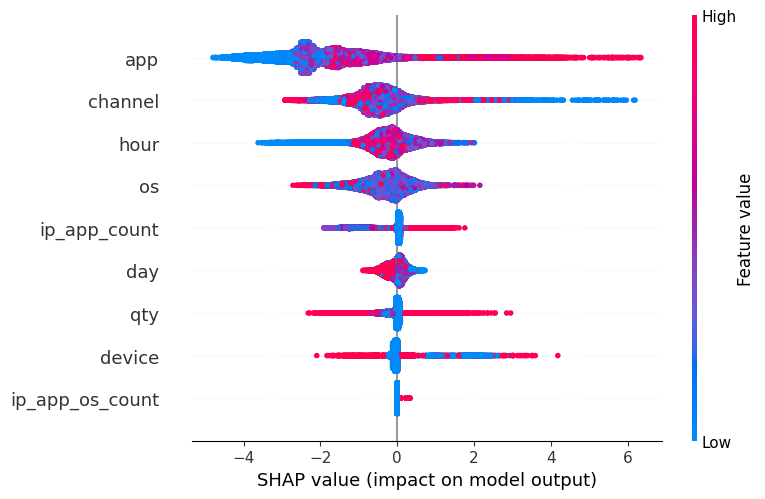

In [13]:
X = X.drop(['pred'], axis=1)
shap.summary_plot(shap_values, X)